# Remote sensing semantic segmentation

# I. Task 1: Implement partial cross-entropy loss

## I.I Implementation of the loss function

In [1]:
import torch
import torch.nn as nn

def partial_cross_entropy_loss(predictions, labels, labeled_mask):
    """
    Compute cross-entropy loss for labeled data points only.

    Args:
        predictions (torch.Tensor): Model predictions (logits) of shape (batch_size, num_classes).
        labels (torch.Tensor): Ground truth labels of shape (batch_size,), with -1 for unlabeled points.
        labeled_mask (torch.Tensor): Boolean mask of shape (batch_size,) where True indicates labeled points.

    Returns:
        torch.Tensor: The computed loss for the labeled points.
    """
    # Filter predictions and labels for labeled points
    labeled_predictions = predictions[labeled_mask]
    labeled_labels = labels[labeled_mask]

    # Ensure there are labeled points to calculate loss
    if labeled_predictions.size(0) == 0:
        return torch.tensor(0.0, device=predictions.device, requires_grad=True)

    # Use standard cross-entropy loss on labeled points
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(labeled_predictions, labeled_labels)

    return loss

## I.II Example usage:

In [2]:
# Simulate a batch of predictions and labels
batch_size = 8
num_classes = 5

# Random logits (predictions) and labels
predictions = torch.randn(batch_size, num_classes, requires_grad=True)
labels = torch.tensor([0, 1, -1, 3, -1, 2, 4, -1])  # -1 indicates unlabeled points

# Create a mask for labeled points
labeled_mask = labels != -1

# Compute the partial cross-entropy loss
loss = partial_cross_entropy_loss(predictions, labels, labeled_mask)
print("Partial Cross-Entropy Loss:", loss.item())

Partial Cross-Entropy Loss: 1.926551103591919


# II. Task 2: Find any remote sensing image segmentation data, randomly sample the simulated point label, and add the loss to any remote sensing segmentation network

## II.I Chosing, loading and visualizing  the dataset:
### CaBuAr: California Burned Areas dataset for delineation

"A novel open dataset that tackles the burned area delineation problem, a binary segmentation problem applied to satellite imagery. The presented resource consists of pre- and post-fire Sentinel-2 L2A acquisitions of California forest fires that took place starting in 2015. Raster annotations were generated from the data released by California's Department of Forestry and Fire Protection"

https://paperswithcode.com/paper/cabuar-california-burned-areas-dataset-for

In [ ]:
!pip install datasets

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# Load the dataset
dataset_post_fire = load_dataset("DarthReca/california_burned_areas", name="post-fire")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

california_burned_areas.py:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

The repository for DarthReca/california_burned_areas contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DarthReca/california_burned_areas.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


512x512.hdf5:   0%|          | 0.00/5.88G [00:00<?, ?B/s]

chabud_test.h5:   0%|          | 0.00/667M [00:00<?, ?B/s]

Generating 0 split: 0 examples [00:00, ? examples/s]

Generating 1 split: 0 examples [00:00, ? examples/s]

Generating 2 split: 0 examples [00:00, ? examples/s]

Generating 3 split: 0 examples [00:00, ? examples/s]

Generating 4 split: 0 examples [00:00, ? examples/s]

Generating chabud split: 0 examples [00:00, ? examples/s]

## II.II Process and visualize few samples of the dataset:

In [5]:
def normalize_image(image):
  """
    Normalize an image to the range [0, 255]. Returns a zero-filled
    image if all pixel values are identical.

    Parameters:
        image (numpy.ndarray): Input image as a NumPy array.

    Returns:
        numpy.ndarray: Normalized image
  """
  min_val = np.min(image)
  max_val = np.max(image)

  # Avoid division by zero
  if max_val - min_val == 0:
    return  np.zeros_like(image, dtype=np.uint8)

  # Normalize to 0-255
  normalized_image = (image - min_val) / (max_val - min_val) * 255
  return normalized_image.astype(np.uint8)

In [6]:
# Visualize images side-by-side
def visualize(image, mask, channels=(9,10 , 11)):
    """
    Display the mask and an RGB-like representation of the image side-by-side.

    Args:
        image (np.ndarray): The input image array.
        mask (np.ndarray): The mask array.
        channels (tuple): Channels to use for RGB visualization.
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Display the mask in the first subplot
    axes[0].imshow(mask[:, :, 0], cmap='gray')  # Assuming single-channel mask
    axes[0].set_title("Mask (Channel 0)")
    axes[0].axis('off')

    # Create RGB-like representation of the image
    rgb_image = np.stack([image[:, :, c] for c in channels], axis=-1)
    axes[1].imshow(rgb_image.astype(np.uint8))
    axes[1].set_title(f"RGB-like Image (Channels {channels})")
    axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

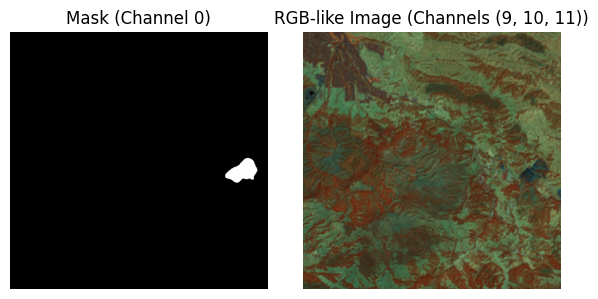

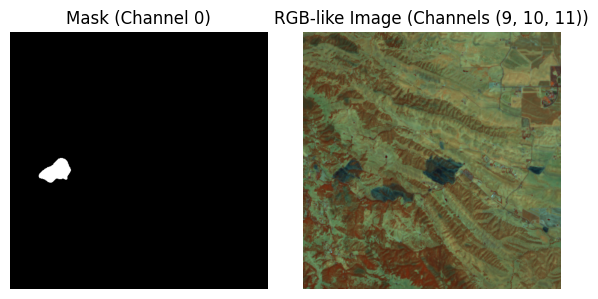

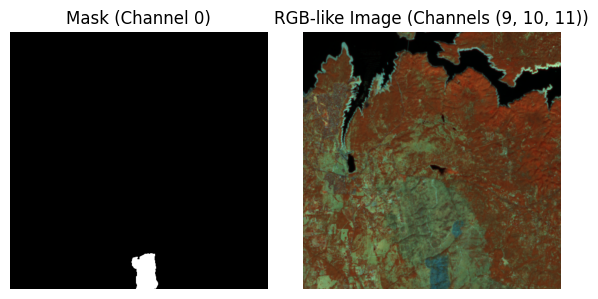

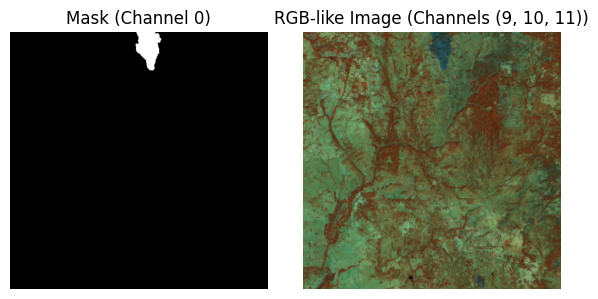

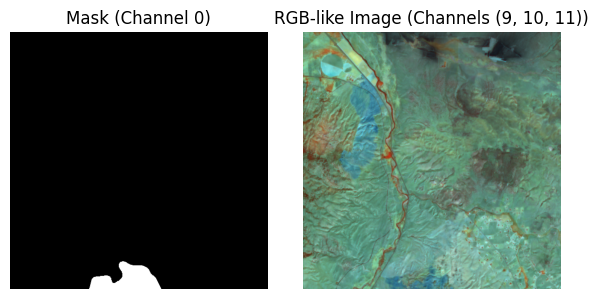

In [7]:
# Process and visualize data examples
num_examples = 5
example_images = [
    normalize_image(
        np.array(dataset_post_fire['0'][idx]['post_fire'])
    ) for idx in range(num_examples)
]
example_masks = [
      np.array(dataset_post_fire['0'][idx]['mask'])
      for idx in range(num_examples)
]
for image, mask in zip(example_images, example_masks):
  visualize(image, mask)

In [8]:
# Randomly sample from the image to transition from the
# Compact (full) remote sensing segmentation to the
# sparse segmentation problem.
# For now we set the sampling ratio at 10%, meaning that
# 10% of the postive area and 10% of the negative area will
# be used when training the model (in the loss function)
def randomly_sample(mask, sample_ratio=0.1):
    """
    Randomly sample 10% of the positive and 10% of the negative area (1s and 0s in the mask)
    and set unselected points to -1.

    Args:
        image (np.ndarray): Input image of shape (512, 512, 3).
        mask (np.ndarray): Binary mask of shape (512, 512, 1).
        sample_ratio (float): Proportion of positive and negative areas to sample.

    Returns:
        np.ndarray: Updated mask with unselected points set to -1.
        tuple: Indices of sampled points in the (H, W) format for both positive and negative areas.
    """
    # Ensure the mask is a single channel
    if len(mask.shape) == 3:
        mask = mask.squeeze(-1)

    # Find the indices of positive and negative areas (where mask value is 1 and 0)
    positive_indices = np.where(mask == 1)
    negative_indices = np.where(mask == 0)

    num_positive_pixels = len(positive_indices[0])
    num_negative_pixels = len(negative_indices[0])

    # Determine the number of positive and negative pixels to sample
    positive_sample_size = int(sample_ratio * num_positive_pixels)
    negative_sample_size = int(sample_ratio * num_negative_pixels)

    # Randomly select indices from the positive and negative areas
    sampled_positive_indices = np.random.choice(
        num_positive_pixels,
        size=positive_sample_size,
        replace=False
    )
    sampled_negative_indices = np.random.choice(
        num_negative_pixels,
        size=negative_sample_size,
        replace=False
    )

    # Create a mask to update unselected points to -1
    updated_mask = np.full_like(mask, -1, dtype=np.int32)

    # Set the sampled positive and negative indices back to 1 and 0 in the updated mask
    selected_positives = (
        positive_indices[0][sampled_positive_indices],
        positive_indices[1][sampled_positive_indices]
    )
    selected_negatives = (
        negative_indices[0][sampled_negative_indices],
        negative_indices[1][sampled_negative_indices]
    )

    updated_mask[selected_positives] = 1
    updated_mask[selected_negatives] = 0

    # Concatenate the selected positive and negative indices into one array
    combined_selected_indices = np.concatenate([selected_positives, selected_negatives], axis=1)

    return updated_mask, combined_selected_indices

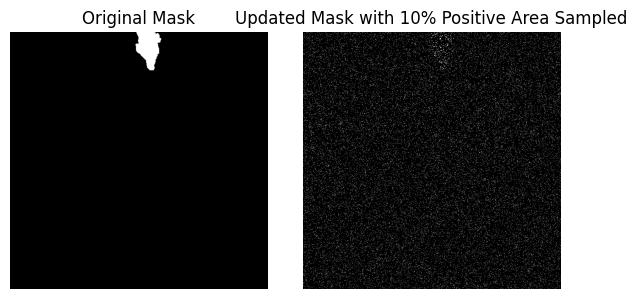

In [9]:
# Dsiplay an example mask before and after sampling
example_mask = example_masks[3]

sample_ratio = 0.1  # Sample 10% of positive area
updated_mask, sampled_indices = randomly_sample(example_mask, sample_ratio)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(example_mask, cmap='gray')
axes[0].set_title("Original Mask")
axes[0].axis('off')

axes[1].imshow(updated_mask, cmap='gray')
axes[1].set_title("Updated Mask with 10% Positive Area Sampled")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Note: the plot below might be confusing because values
# set to -1 and and 0 will show up in the same color

# III Modeling:
### The idea is to train a Umap segmentation model on the sparse remote sensing segmentation task.

## III.I Creating the dataset and dataloader Classes

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define the custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, dataset_dict, folds, channels=(9,10 , 11), sample_ratio=0.1):
        """
        Args:
            images: dictionary {'fold': list of images}.
            folds (list): list of folds to be included (e.g., ['fold 1', 'fold 2']).
        """
        self.images = []
        self.masks = []
        self.sample_ratio = sample_ratio

        # load and process images and masks
        for fold in folds:
          print(f"Processing fold {fold}")
          for idx in tqdm(range(len(dataset_dict[fold]))):
            self.images.append(
                # Applying same processing as in section II.II
                np.stack(
                    [
                        normalize_image(
                            np.array(
                                dataset_post_fire[fold][idx]['post_fire'])[:, :, c]
                        ) for c in channels
                    ],
                axis=-1
                )
            )
            self.masks.append(
                np.array(
                    dataset_post_fire[fold][idx]['mask']
                )
            )

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """Fetch an image-mask pair by index."""
        image = self.images[idx]
        mask = self.masks[idx]
        updated_mask, _ = randomly_sample(example_mask, sample_ratio)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        updated_mask = torch.tensor(updated_mask, dtype=torch.long)

        return image, updated_mask

In [15]:
# Select training and testing folds
train_folds = list(dataset_post_fire.keys())[:-1]
validation_folds = [list(dataset_post_fire.keys())[-1]]

# Create an instance of the dataset class for the selected fold
train_dataset = SegmentationDataset(dataset_post_fire, train_folds)
validation_dataset = SegmentationDataset(dataset_post_fire, validation_folds)

# Create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16)

Processing fold 0


100%|██████████| 130/130 [09:34<00:00,  4.42s/it]


Processing fold 1


100%|██████████| 104/104 [07:27<00:00,  4.30s/it]


Processing fold 2


100%|██████████| 99/99 [07:09<00:00,  4.34s/it]


Processing fold 3


100%|██████████| 109/109 [07:45<00:00,  4.27s/it]


Processing fold 4


100%|██████████| 92/92 [06:20<00:00,  4.14s/it]


Processing fold chabud


100%|██████████| 68/68 [04:45<00:00,  4.20s/it]


## III.II Model training

In [ ]:
!pip install segmentation-models-pytorch

In [57]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from segmentation_models_pytorch import Unet
from tqdm import tqdm
import torch.optim as optim

# Define the Unet model
model = Unet(
    encoder_name="resnet34",  # CNN backbone
    encoder_weights="imagenet",  # Use pretrained weights
    in_channels=3,  # Input channels (RGB)
    classes=1,  # Output channels (binary segmentation)
).to("cuda" if torch.cuda.is_available() else "cpu")

# Define loss and optimizer
loss_fn = partial_cross_entropy_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# IoU calculation
def calculate_iou(predictions, targets, threshold=0.5):
    predictions = (torch.sigmoid(predictions) > threshold).float()
    intersection = (predictions * targets).sum(dim=(1, 2, 3))
    union = (predictions + targets).sum(dim=(1, 2, 3)) - intersection
    iou = intersection / (union + 1e-6)
    return iou.mean().item()

# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 10
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    for images, masks in tqdm(train_dataloader, desc="Training"):

        # Convert HWC to CHW
        images = np.transpose(images, (0, 3, 1, 2)).to(device)
        masks =  masks.to(device)

        # Forward pass
        outputs = model(images)
        labeled_mask = masks != -1
        loss = loss_fn(outputs.squeeze(1).float(), masks.float(), labeled_mask)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += calculate_iou(outputs, masks.unsqueeze(1))

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(validation_dataloader, desc="Validation"):
            images = np.transpose(images, (0, 3, 1, 2)).to(device)
            masks =  masks.to(device)

            # Forward pass
            outputs = model(images)
            labeled_mask = masks != -1
            loss = loss_fn(outputs.squeeze(1).float(), masks.float(), labeled_mask)

            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks.unsqueeze(1))

    val_loss /= len(validation_dataloader)
    val_iou /= len(validation_dataloader)
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

# Save the model
torch.save(model.state_dict(), "unet_model.pth")

Epoch 1/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Train Loss: 42697.5398, Train IoU: 0.1765


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Val Loss: 53908.3668, Val IoU: 0.0493
Epoch 2/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Train Loss: 35506.0690, Train IoU: 0.1078


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Val Loss: 30849.6615, Val IoU: 0.0514
Epoch 3/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.17s/it]


Train Loss: 34948.9503, Train IoU: 0.0050


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Val Loss: 29773.6666, Val IoU: 0.1183
Epoch 4/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.17s/it]


Train Loss: 34568.4824, Train IoU: 0.0261


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Val Loss: 29671.9446, Val IoU: 0.0559
Epoch 5/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Train Loss: 34520.6235, Train IoU: -0.0273


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Val Loss: 29564.1914, Val IoU: 0.0592
Epoch 6/10


Training: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]


Train Loss: 34457.1114, Train IoU: 0.0796


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Val Loss: 29538.8791, Val IoU: 0.1057
Epoch 7/10


Training: 100%|██████████| 34/34 [00:40<00:00,  1.18s/it]


Train Loss: 34357.6542, Train IoU: 0.0636


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Val Loss: 29478.3453, Val IoU: 0.0788
Epoch 8/10


Training: 100%|██████████| 34/34 [00:41<00:00,  1.21s/it]


Train Loss: 34378.5959, Train IoU: 0.0710


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Val Loss: 29457.4096, Val IoU: 0.0611
Epoch 9/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.17s/it]


Train Loss: 34341.8008, Train IoU: 0.0650


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Val Loss: 29616.1854, Val IoU: 0.0786
Epoch 10/10


Training: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Train Loss: 34358.7524, Train IoU: 0.0674


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Val Loss: 29460.0671, Val IoU: 0.0608
